In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

sns.set_style("whitegrid")
pd.options.display.float_format = '{:.6f}'.format


In [2]:

# Load Dataset
file_path = "stock_details_5_years.csv"
df = pd.read_csv(file_path)

# Understand Structure
print("Shape of dataset:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())
print("\nData Types:\n", df.dtypes)

# Summary Statistics
print("\nSummary Statistics:\n", df.describe(include='all'))

# Missing Value Analysis
print("\nMissing values per column:\n", df.isnull().sum())
missing_percentage = df.isnull().mean() * 100
print("\nMissing value percentage:\n", missing_percentage)

# Handle Duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()

# Convert Data Types Safely
# Convert Date column to datetime, keep invalid as NaT
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("Number of invalid dates:", df['Date'].isnull().sum())

# Only convert numeric columns that exist
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
existing_numeric_cols = [col for col in numeric_cols if col in df.columns]

for col in existing_numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # invalid entries become NaN
    df[col] = df[col].fillna(df[col].median())  # fill missing numeric values

# Handle Missing Values in Other Columns
non_numeric_cols = df.select_dtypes(exclude=[np.number, 'datetime']).columns
for col in non_numeric_cols:
    df[col] = df[col].fillna("Unknown")

# Outlier Detection (IQR method)
for col in existing_numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"Outliers in {col}: {outliers}")

# Save Cleaned Dataset
df.to_csv("cleaned_stock_details_5_years.csv", index=False)
print("\n Data cleaning complete. All rows preserved and saved as 'cleaned_stock_details_5_years.csv'")

Shape of dataset: (602962, 9)

Column names: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Company']

First 5 rows:
                         Date       Open       High        Low      Close  \
0  2018-11-29 00:00:00-05:00  43.829761  43.863354  42.639594  43.083508   
1  2018-11-29 00:00:00-05:00 104.769074 105.519257 103.534595 104.636131   
2  2018-11-29 00:00:00-05:00  54.176498  55.007500  54.099998  54.729000   
3  2018-11-29 00:00:00-05:00  83.749496  84.499496  82.616501  83.678497   
4  2018-11-29 00:00:00-05:00  39.692784  40.064904  38.735195  39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000   0.000000      0.000000    AAPL  
1   28123200   0.000000      0.000000    MSFT  
2   31004000   0.000000      0.000000   GOOGL  
3  132264000   0.000000      0.000000    AMZN  
4   54917200   0.040000      0.000000    NVDA  

Data Types:
 Date             object
Open            float64
High            float64
Low             f

In [3]:
# Load the dataset
file_path = "cleaned_stock_details_5_years.csv"
df = pd.read_csv(file_path)

# View the first 5 rows and columns
print(df.head())
print(df.columns)

# Create Adjusted Close
if 'Close' in df.columns:
    # Assuming no splits for simplicity, only adjust for dividends
    if 'Dividends' in df.columns:
        df['Adj Close'] = (df['Close'] + df['Dividends']).round(3)
    else:
        df['Adj Close'] = df['Close'].round(3)
else:
    print("No 'Close' column found in the dataset.")

# Save the updated dataset
df.to_csv('adjusted_dataset.csv', index=False)
print("Adjusted Close column created and dataset saved as 'adjusted_dataset.csv'")

                        Date       Open       High        Low      Close  \
0  2018-11-29 00:00:00-05:00  43.829761  43.863354  42.639594  43.083508   
1  2018-11-29 00:00:00-05:00 104.769074 105.519257 103.534595 104.636131   
2  2018-11-29 00:00:00-05:00  54.176498  55.007500  54.099998  54.729000   
3  2018-11-29 00:00:00-05:00  83.749496  84.499496  82.616501  83.678497   
4  2018-11-29 00:00:00-05:00  39.692784  40.064904  38.735195  39.037853   

      Volume  Dividends  Stock Splits Company  
0  167080000   0.000000      0.000000    AAPL  
1   28123200   0.000000      0.000000    MSFT  
2   31004000   0.000000      0.000000   GOOGL  
3  132264000   0.000000      0.000000    AMZN  
4   54917200   0.040000      0.000000    NVDA  
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Company'],
      dtype='object')
Adjusted Close column created and dataset saved as 'adjusted_dataset.csv'


In [4]:
# =====================================
# Step 1: Sort, clean, and prepare Date
# =====================================
df = df.sort_values(['Company', 'Date']).reset_index(drop=True)

# Convert to datetime (coerce invalid entries to NaT)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Remove timezone if present
if pd.api.types.is_datetime64tz_dtype(df['Date']):
    df['Date'] = df['Date'].dt.tz_localize(None)

# Drop rows where Date is NaT
df = df.dropna(subset=['Date']).reset_index(drop=True)


# =====================================
# Step 2: Define feature engineering
# =====================================
def add_features(g):
    g = g.sort_values('Date').copy()
    g['Date'] = pd.to_datetime(g['Date'], errors='coerce')

    # Lagged values
    g['prev_adj'] = g['Adj Close'].shift(1)

    # Returns
    g['daily_ret'] = (g['Adj Close'] - g['prev_adj']) / g['prev_adj']
    g['intraday_ret'] = (g['Adj Close'] - g['Open']) / g['Open']
    g['overnight_gap'] = (g['Open'] - g['prev_adj']) / g['prev_adj']
    g['abs_intraday'] = g['intraday_ret'].abs()

    # Binary target
    g['target_up'] = (g['intraday_ret'] > 0).astype(int)

    # Time features
    g['weekday'] = g['Date'].dt.day_name()
    g['month']   = g['Date'].dt.month
    g['year']    = g['Date'].dt.year

    # Rolling volume stats (20-day)
    if 'Volume' in g.columns:
        g['vol_roll_mean'] = g['Volume'].rolling(20, min_periods=5).mean()
        g['vol_roll_std']  = g['Volume'].rolling(20, min_periods=5).std()
        g['vol_zscore']    = (g['Volume'] - g['vol_roll_mean']) / g['vol_roll_std']
        g['vol_spike']     = (g['vol_zscore'] > 2).astype(int)
    else:
        g['vol_zscore'] = 0.0
        g['vol_spike'] = 0

    return g


# =====================================
# Step 3: Apply features to each company
# =====================================
df = df.groupby('Company', group_keys=False).apply(add_features).reset_index(drop=True)

# Drop problematic rows
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['daily_ret', 'intraday_ret', 'overnight_gap'])


# =====================================
# Step 4: Compute Average Daily Return by Month
# =====================================
avg_monthly = (
    df.groupby(['Company', 'month'])['daily_ret']
    .mean()
    .reset_index()
    .rename(columns={'daily_ret': 'avg_daily_ret_month'})
)

print(avg_monthly.head())


  Company     month  avg_daily_ret_month
0       A  1.000000            -0.000034
1       A  2.000000            -0.001400
2       A  3.000000            -0.001018
3       A 11.000000             0.005119
4       A 12.000000             0.000357


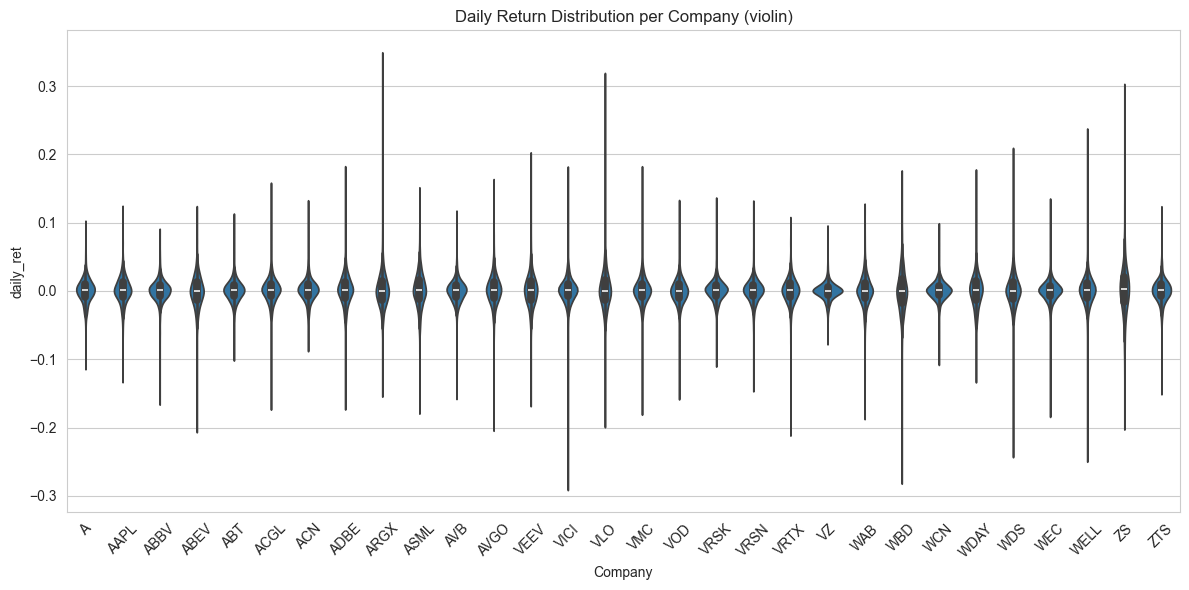

In [5]:
# Violin plot per Company (limit to first 30 Company for readability)
plt.figure(figsize=(12,6))
plot_df = df.copy()
# if many companies, keep top N by count
top_companies = plot_df['Company'].value_counts().nlargest(30).index
sns.violinplot(x='Company', y='daily_ret', data=plot_df[plot_df['Company'].isin(top_companies)], cut=1)
plt.title('Daily Return Distribution per Company (violin)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

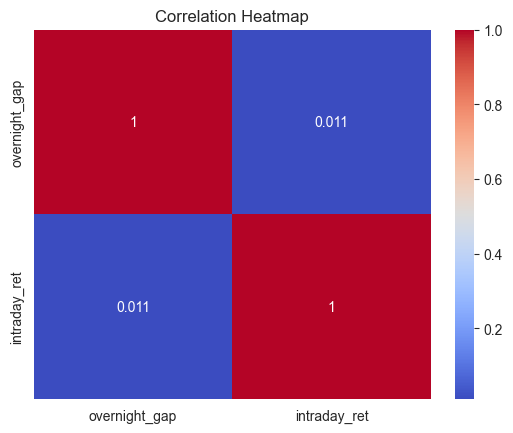

In [6]:
#Heatmap

corr = df[['overnight_gap','intraday_ret']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

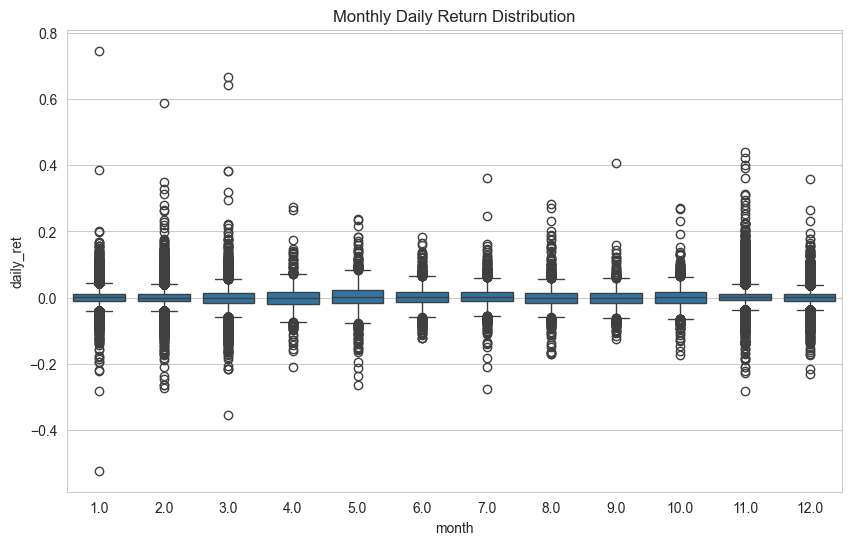

In [7]:
# Box Plot

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='month', y='daily_ret')
plt.title("Monthly Daily Return Distribution")
plt.show()

Top 5 Companies by Average Return: ['SYM', 'LI', 'OXY', 'BNTX', 'CARR']


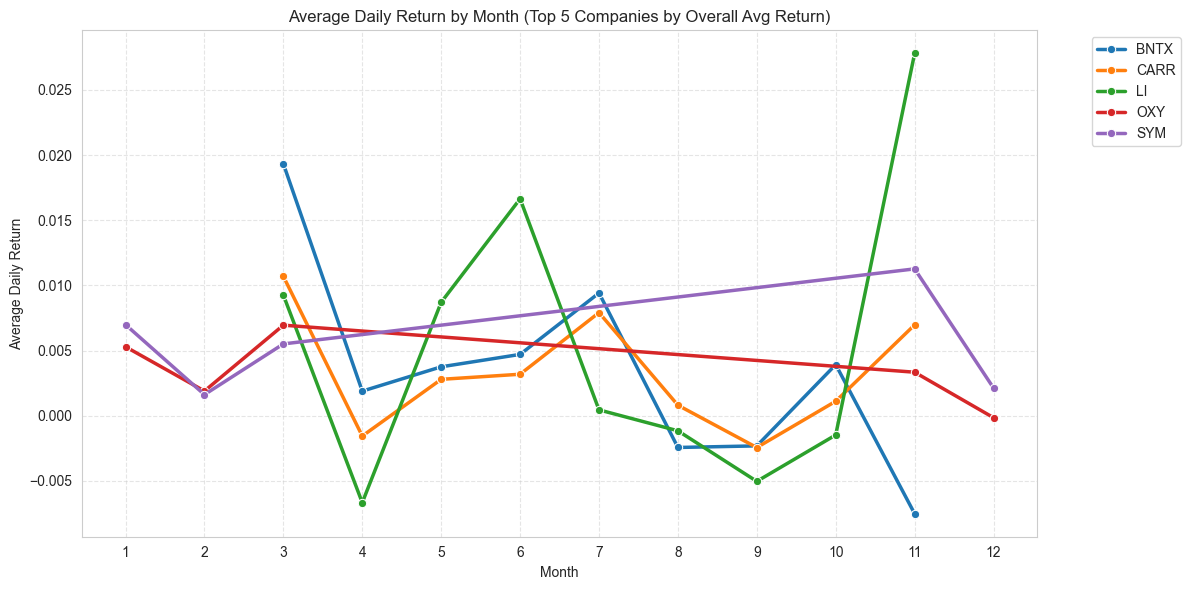

In [8]:
# Calculate the overall average return for each company (across all months)
overall_avg = avg_monthly.groupby('Company')['avg_daily_ret_month'].mean().reset_index()

# Sort by the average return in descending order and get the top 5
top_5_companies = overall_avg.nlargest(5, 'avg_daily_ret_month')['Company'].tolist()

print("Top 5 Companies by Average Return:", top_5_companies)

# Filter the data for plotting
plot_data = avg_monthly[avg_monthly['Company'].isin(top_5_companies)]

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_data, x='month', y='avg_daily_ret_month', hue='Company', marker='o', linewidth=2.5)

plt.title("Average Daily Return by Month (Top 5 Companies by Overall Avg Return)")
plt.xlabel("Month")
plt.ylabel("Average Daily Return")
plt.xticks(range(1,13))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Moves legend outside the plot
plt.tight_layout() # Adjusts layout to fit everything
plt.show()